<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Olivia/DIST_GAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt



In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [4]:


def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
          s=ax[i].imshow(np.squeeze(samples[i,]))
          s=ax[i].get_xaxis().set_visible(False)
          s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [5]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [11]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        c =64
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=128)
        initialize_weights(self)   
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

In [7]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x




class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size



 
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

# DIST-GAN Network 

---

1. Autoencoder optimization $\min_{A}  \Big({\rm BCE}\left((x_{\rm real}),\underbrace{X_r{\rm recon}}_{1}\right) + {\rm BCE}\left(G(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{X_f{\rm fake}}_0\right)\Big)
$


2. Generator optimization $\min_{G}  ~{\rm BCE}\left(D(\underbrace{X_f{\rm fake}}_{G[z]}),\underbrace{X_r{\rm real}}_1\right)$

<font color=red>The generator tries to assign $D(x_{\rm fake}) \rightarrow 1$ </font>.




In [12]:

from torch.autograd import grad as torch_grad
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

     
        self.lamda_p = 1.0     # regularization term of gradient penalty
        self.lamda_r = 1.0    # autoencoders regularization term  
       
        
        
        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        #print(data.shape[0])

        # initialization of the generator and discriminator and autoencoder 
        self.A = autoencoder().cuda()
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
      

        self.A_optimizer =  optim.Adam(self.A.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
        # initialization of the loss function Hinge Embedding loss ( from paper )
       
        self.BCE = nn.BCEWithLogitsLoss().cuda()
     
        
        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                z_ = torch.rand((self.batch_size, self.z_dim))
                #x_ = x_.view(x_.size(0), -1)
               # z_ = z_.view(z_.size(0), -1)
                x_, z_ = x_.cuda() ,z_.cuda()
        
        

                #-------------Train Autoencoder & Generator to minimize reconstruction loss ------------# 
                # auto-encoders and its regularization

                torch.autograd.set_detect_anomaly(True)
                # reconstructed image
                recon = self.A(x_)
                X_r = self.G(recon) # reconstructed iamges from generator 
               # print("\tX_r:", X_r.shape)
                X_f = self.G(z_) # fake images from generator 
                #print("\tX_f:", X_f.shape)
                X_r, X_f = X_r, X_f

                D_real = self.D(x_)
                D_recon = self.D(X_r)
                D_fake = self.D(X_f)


                ## auto-encoders and Regularization from Dist-Gan paper 

                R_loss = torch.mean(torch.square(D_real-D_recon))
                #print("\tR_loss:", R_loss.shape)
                f = torch.mean(D_recon - D_fake) #distance between reconstructed imgs and reconstructed fake imgs 
                #print("\tf:", f.shape)
                g = torch.mean(recon - z_) * 0.8838  # distance between reconstruced imgs and noise
                #print("\tg:", g.shape)
                R_reg = torch.square(f - g)

               
                
                # train Autoencoder with R_loss 
                R_loss = R_loss + self.lamda_r * R_reg
                #print("\tR_loss", R_loss.shape)
                self.A_optimizer.zero_grad()
                R_loss.backward(retain_graph=True)
                self.A_optimizer.step()


                #train Generator with G_Loss 
                self.G_optimizer.zero_grad()
               
                G_loss = self.BCE(D_real,D_fake)
                G_loss.backward()
                self.G_optimizer.step()



               #-----------Train Discriminator --------#######

                #Train Discriminator with Discriminator Score 
                D_real = self.D(x_.detach())
                D_recon = self.D(X_r.detach())
                D_fake = self.D(X_f.detach())


                # interpolation     
                epsilon = torch.rand(x_.size())
                epsilon = epsilon.cuda()
                interpolation = x_ * epsilon + (1-epsilon) * X_f
                d_inter = self.D(interpolation)
                # Gradien Penalty 
                gradients = torch_grad(d_inter, interpolation, grad_outputs=torch.ones(d_inter.size()).cuda())[0]
              
                slopes = torch.square(torch.mean(torch.square(gradients)))
                gp = torch.mean((slopes-1)**2)
            
 
            
                # Discriminator loss on data
                d_loss_real = torch.mean(self.BCE( D_real,self.y_real_))
                d_loss_recon = torch.mean(self.BCE(D_recon, torch.zeros_like(D_recon)))
                d_loss_fake = torch.mean(self.BCE(D_fake,self.y_fake_))

                # loss w.r.t gradient penalty and reconstruction term 
                D_loss = d_loss_real + d_loss_recon + d_loss_fake
                D_loss = D_loss + self.lamda_p * gp

          
              
                #train Discriminator 
                self.D_optimizer.zero_grad()
                D_loss.backward(retain_graph=True)
                self.D_optimizer.step()



                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
      
     
                

                #---------------Train Generator to minimize discriminator score --------#
                D_real = self.D(x_.detach())
                D_recon = self.D(X_r.detach())
                D_fake = self.D(X_f.detach())
             
                self.G_optimizer.zero_grad()
                G_loss = torch.abs(torch.mean(D_real) - torch.mean(D_fake))
                G_loss.backward(retain_graph=True)
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 50) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
    
                      # Visualize results
            with torch.no_grad():
              visualize_results(self)
            if (epoch% 10 ) == 0:  
              print("10")

              print('Generator Reconstruction Images at 10 Epoch')
              visualise_output(self)
            if (epoch% 20 ) == 0:  
              print("20")

              print('Generator Reconstruction Images at 20 Epoch')
              visualise_output(self)
            if (epoch% 30 ) == 0:  
              print("30")

              print('Generator Reconstruction Images at 30 Epoch')
              visualise_output(self)
            if (epoch% 40 ) == 0:  
              print("40")

              print('Generator Reconstruction Images at 40 Epoch')
              visualise_output(self)

        print("Training finished!")

In [9]:
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils

def visualise_output(gan):

    with torch.no_grad():
        sample_z_ = torch.rand((gan.base_size, gan.z_dim)).cuda()
        samples = gan.G(sample_z_)
        samples = samples.cpu()
        samples = (samples + 1) / 2
        np_imagegrid = torchvision.utils.make_grid(samples[1:100], 10, 5).detach().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

def digit_frequency(gan): 
  with torch.no_grad():
    z = torch.rand((gan.base_size, gan.z_dim)).cuda()
    z = gan.G(z)
    z = z.cpu()
    unique, counts = np.unique(z, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique)
    plt.xlabel("Label")
    plt.ylabel("Quantity")
    plt.title("Labels in MNIST 784 dataset")

training start!!
Epoch: [ 1] [  50/ 200] D_loss: 3.09575486, G_loss: 0.21178010
Epoch: [ 1] [ 100/ 200] D_loss: 2.95720005, G_loss: 0.50944388
Epoch: [ 1] [ 150/ 200] D_loss: 2.91222835, G_loss: 0.62624514
Epoch: [ 1] [ 200/ 200] D_loss: 2.90468025, G_loss: 0.66550905


<Figure size 72x720 with 0 Axes>

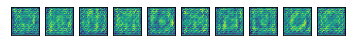

10
Generator Reconstruction Images at 10 Epoch


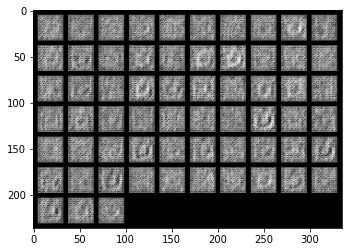

20
Generator Reconstruction Images at 20 Epoch


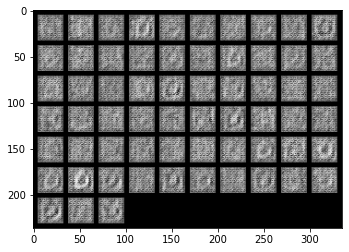

30
Generator Reconstruction Images at 30 Epoch


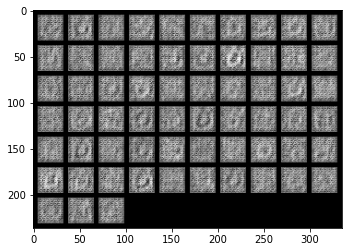

40
Generator Reconstruction Images at 40 Epoch


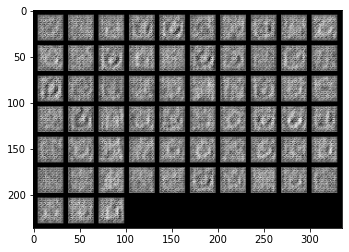

Epoch: [ 2] [  50/ 200] D_loss: 2.90478945, G_loss: 0.64751637
Epoch: [ 2] [ 100/ 200] D_loss: 2.89448524, G_loss: 0.66801572
Epoch: [ 2] [ 150/ 200] D_loss: 2.88272977, G_loss: 0.70744759
Epoch: [ 2] [ 200/ 200] D_loss: 2.87215996, G_loss: 0.75470179


<Figure size 72x720 with 0 Axes>

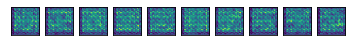

Epoch: [ 3] [  50/ 200] D_loss: 2.86026669, G_loss: 0.79331660
Epoch: [ 3] [ 100/ 200] D_loss: 2.85916519, G_loss: 0.78801399
Epoch: [ 3] [ 150/ 200] D_loss: 2.85758162, G_loss: 0.79666412
Epoch: [ 3] [ 200/ 200] D_loss: 2.84766865, G_loss: 0.83186662


<Figure size 72x720 with 0 Axes>

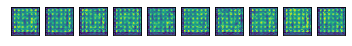

Epoch: [ 4] [  50/ 200] D_loss: 2.84234190, G_loss: 0.85304040
Epoch: [ 4] [ 100/ 200] D_loss: 2.84779692, G_loss: 0.83202392
Epoch: [ 4] [ 150/ 200] D_loss: 2.83706331, G_loss: 0.86891818
Epoch: [ 4] [ 200/ 200] D_loss: 2.83140683, G_loss: 0.88517827


<Figure size 72x720 with 0 Axes>

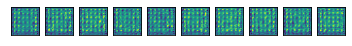

Epoch: [ 5] [  50/ 200] D_loss: 2.83336306, G_loss: 0.88186771
Epoch: [ 5] [ 100/ 200] D_loss: 2.84808254, G_loss: 0.83746916
Epoch: [ 5] [ 150/ 200] D_loss: 2.82961464, G_loss: 0.89156485
Epoch: [ 5] [ 200/ 200] D_loss: 2.83913398, G_loss: 0.86774945


<Figure size 72x720 with 0 Axes>

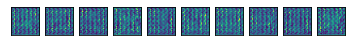

Epoch: [ 6] [  50/ 200] D_loss: 2.84786177, G_loss: 0.83876455
Epoch: [ 6] [ 100/ 200] D_loss: 2.83217096, G_loss: 0.88292414
Epoch: [ 6] [ 150/ 200] D_loss: 2.86541510, G_loss: 0.78777701
Epoch: [ 6] [ 200/ 200] D_loss: 2.92910051, G_loss: 0.54915583


<Figure size 72x720 with 0 Axes>

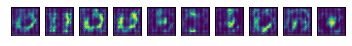

Epoch: [ 7] [  50/ 200] D_loss: 2.90155220, G_loss: 0.67324412
Epoch: [ 7] [ 100/ 200] D_loss: 2.87109280, G_loss: 0.76739544
Epoch: [ 7] [ 150/ 200] D_loss: 2.87623239, G_loss: 0.73689991
Epoch: [ 7] [ 200/ 200] D_loss: 2.95357656, G_loss: 0.61410081


<Figure size 72x720 with 0 Axes>

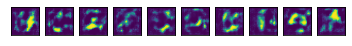

Epoch: [ 8] [  50/ 200] D_loss: 2.87294602, G_loss: 0.78122371
Epoch: [ 8] [ 100/ 200] D_loss: 2.86827779, G_loss: 0.77141005
Epoch: [ 8] [ 150/ 200] D_loss: 2.86084485, G_loss: 0.80465239
Epoch: [ 8] [ 200/ 200] D_loss: 2.84863043, G_loss: 0.83354664


<Figure size 72x720 with 0 Axes>

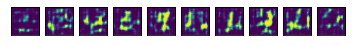

Epoch: [ 9] [  50/ 200] D_loss: 2.85505128, G_loss: 0.81576478
Epoch: [ 9] [ 100/ 200] D_loss: 2.85780048, G_loss: 0.80038130
Epoch: [ 9] [ 150/ 200] D_loss: 2.84453678, G_loss: 0.85016716
Epoch: [ 9] [ 200/ 200] D_loss: 2.84746552, G_loss: 0.84479171


<Figure size 72x720 with 0 Axes>

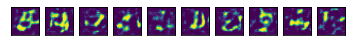

Epoch: [10] [  50/ 200] D_loss: 2.84844255, G_loss: 0.85044193
Epoch: [10] [ 100/ 200] D_loss: 2.90205741, G_loss: 0.68301576
Epoch: [10] [ 150/ 200] D_loss: 2.84081745, G_loss: 0.86551976
Epoch: [10] [ 200/ 200] D_loss: 2.85662055, G_loss: 0.82992345


<Figure size 72x720 with 0 Axes>

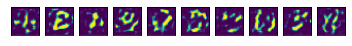

Epoch: [11] [  50/ 200] D_loss: 2.88617039, G_loss: 0.78125364
Epoch: [11] [ 100/ 200] D_loss: 2.85799623, G_loss: 0.83493239
Epoch: [11] [ 150/ 200] D_loss: 2.84129238, G_loss: 0.87176150
Epoch: [11] [ 200/ 200] D_loss: 2.83531380, G_loss: 0.88321537


<Figure size 72x720 with 0 Axes>

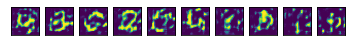

10
Generator Reconstruction Images at 10 Epoch


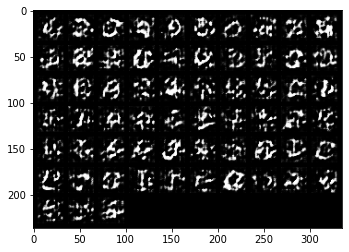

Epoch: [12] [  50/ 200] D_loss: 2.84429026, G_loss: 0.84685981
Epoch: [12] [ 100/ 200] D_loss: 2.83163261, G_loss: 0.89376128
Epoch: [12] [ 150/ 200] D_loss: 2.82807207, G_loss: 0.90176630
Epoch: [12] [ 200/ 200] D_loss: 2.82189822, G_loss: 0.92141700


<Figure size 72x720 with 0 Axes>

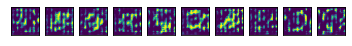

Epoch: [13] [  50/ 200] D_loss: 2.81894159, G_loss: 0.93214309
Epoch: [13] [ 100/ 200] D_loss: 2.82154655, G_loss: 0.92442608
Epoch: [13] [ 150/ 200] D_loss: 2.82127023, G_loss: 0.92647654
Epoch: [13] [ 200/ 200] D_loss: 2.82767725, G_loss: 0.90167809


<Figure size 72x720 with 0 Axes>

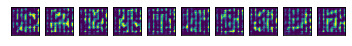

Epoch: [14] [  50/ 200] D_loss: 2.82470894, G_loss: 0.91172254
Epoch: [14] [ 100/ 200] D_loss: 2.82757187, G_loss: 0.90091825
Epoch: [14] [ 150/ 200] D_loss: 2.82015586, G_loss: 0.92558688
Epoch: [14] [ 200/ 200] D_loss: 2.81979251, G_loss: 0.92718107


<Figure size 72x720 with 0 Axes>

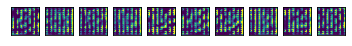

Epoch: [15] [  50/ 200] D_loss: 2.81497622, G_loss: 0.94473952
Epoch: [15] [ 100/ 200] D_loss: 2.84054422, G_loss: 0.88129318
Epoch: [15] [ 150/ 200] D_loss: 2.82180023, G_loss: 0.92162877
Epoch: [15] [ 200/ 200] D_loss: 2.81986189, G_loss: 0.92848164


<Figure size 72x720 with 0 Axes>

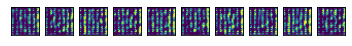

Epoch: [16] [  50/ 200] D_loss: 2.81533861, G_loss: 0.94678956
Epoch: [16] [ 100/ 200] D_loss: 2.82033682, G_loss: 0.93125439
Epoch: [16] [ 150/ 200] D_loss: 2.82224321, G_loss: 0.91924411
Epoch: [16] [ 200/ 200] D_loss: 2.82284904, G_loss: 0.91817027


<Figure size 72x720 with 0 Axes>

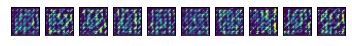

Epoch: [17] [  50/ 200] D_loss: 2.86132097, G_loss: 0.80498886
Epoch: [17] [ 100/ 200] D_loss: 2.89825010, G_loss: 0.69639069
Epoch: [17] [ 150/ 200] D_loss: 2.93136930, G_loss: 0.62293166
Epoch: [17] [ 200/ 200] D_loss: 2.94933510, G_loss: 0.61365217


<Figure size 72x720 with 0 Axes>

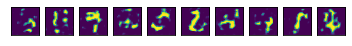

Epoch: [18] [  50/ 200] D_loss: 2.95321727, G_loss: 0.64971048
Epoch: [18] [ 100/ 200] D_loss: 2.87912059, G_loss: 0.80648082
Epoch: [18] [ 150/ 200] D_loss: 2.85438490, G_loss: 0.84236443
Epoch: [18] [ 200/ 200] D_loss: 2.85534358, G_loss: 0.81694466


<Figure size 72x720 with 0 Axes>

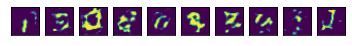

Epoch: [19] [  50/ 200] D_loss: 2.86608291, G_loss: 0.68524081
Epoch: [19] [ 100/ 200] D_loss: 2.88243270, G_loss: 0.84016031
Epoch: [19] [ 150/ 200] D_loss: 2.86402130, G_loss: 0.67828727
Epoch: [19] [ 200/ 200] D_loss: 2.84303665, G_loss: 0.87239689


<Figure size 72x720 with 0 Axes>

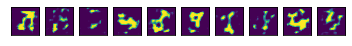

Epoch: [20] [  50/ 200] D_loss: 2.84566808, G_loss: 0.84597552
Epoch: [20] [ 100/ 200] D_loss: 2.84213066, G_loss: 0.85887194
Epoch: [20] [ 150/ 200] D_loss: 2.83515239, G_loss: 0.88174552
Epoch: [20] [ 200/ 200] D_loss: 2.82890534, G_loss: 0.89698905


<Figure size 72x720 with 0 Axes>

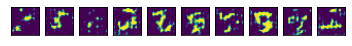

Epoch: [21] [  50/ 200] D_loss: 2.82851100, G_loss: 0.90356100
Epoch: [21] [ 100/ 200] D_loss: 2.82831430, G_loss: 0.90559465
Epoch: [21] [ 150/ 200] D_loss: 2.82399678, G_loss: 0.91731125
Epoch: [21] [ 200/ 200] D_loss: 2.82139373, G_loss: 0.92800748


<Figure size 72x720 with 0 Axes>

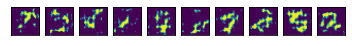

10
Generator Reconstruction Images at 10 Epoch


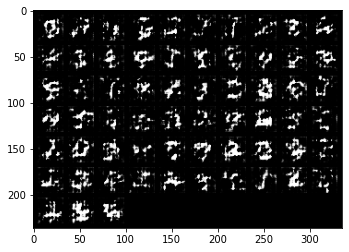

20
Generator Reconstruction Images at 20 Epoch


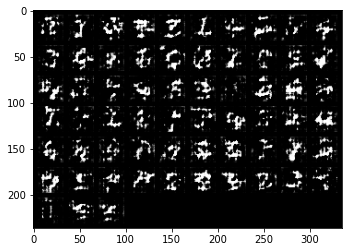

Epoch: [22] [  50/ 200] D_loss: 2.81914616, G_loss: 0.93099719
Epoch: [22] [ 100/ 200] D_loss: 2.81848550, G_loss: 0.93522590
Epoch: [22] [ 150/ 200] D_loss: 2.82241011, G_loss: 0.92430985
Epoch: [22] [ 200/ 200] D_loss: 3.06168222, G_loss: 0.38182956


<Figure size 72x720 with 0 Axes>

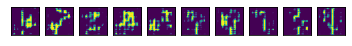

Epoch: [23] [  50/ 200] D_loss: 2.82961750, G_loss: 0.89367670
Epoch: [23] [ 100/ 200] D_loss: 2.82459807, G_loss: 0.91659945
Epoch: [23] [ 150/ 200] D_loss: 2.81948423, G_loss: 0.93032682
Epoch: [23] [ 200/ 200] D_loss: 2.81856823, G_loss: 0.94179469


<Figure size 72x720 with 0 Axes>

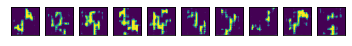

Epoch: [24] [  50/ 200] D_loss: 2.82507896, G_loss: 0.92066753
Epoch: [24] [ 100/ 200] D_loss: 2.81816006, G_loss: 0.93827403
Epoch: [24] [ 150/ 200] D_loss: 2.82097912, G_loss: 0.92926013
Epoch: [24] [ 200/ 200] D_loss: 2.82021594, G_loss: 0.93270242


<Figure size 72x720 with 0 Axes>

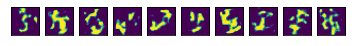

Epoch: [25] [  50/ 200] D_loss: 2.82958317, G_loss: 0.90285552
Epoch: [25] [ 100/ 200] D_loss: 2.82502198, G_loss: 0.91512489
Epoch: [25] [ 150/ 200] D_loss: 2.83122039, G_loss: 0.89620548
Epoch: [25] [ 200/ 200] D_loss: 2.83506060, G_loss: 0.90083838


<Figure size 72x720 with 0 Axes>

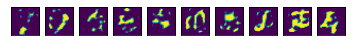

Epoch: [26] [  50/ 200] D_loss: 2.83561206, G_loss: 0.89231652
Epoch: [26] [ 100/ 200] D_loss: 2.83897877, G_loss: 0.82823086
Epoch: [26] [ 150/ 200] D_loss: 2.82272720, G_loss: 0.92464358
Epoch: [26] [ 200/ 200] D_loss: 2.83169580, G_loss: 0.89056164


<Figure size 72x720 with 0 Axes>

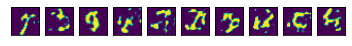

Epoch: [27] [  50/ 200] D_loss: 2.82570004, G_loss: 0.91327822
Epoch: [27] [ 100/ 200] D_loss: 2.81814861, G_loss: 0.93678439
Epoch: [27] [ 150/ 200] D_loss: 2.81415844, G_loss: 0.94858706
Epoch: [27] [ 200/ 200] D_loss: 2.82089424, G_loss: 0.92793798


<Figure size 72x720 with 0 Axes>

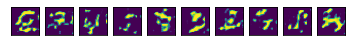

Epoch: [28] [  50/ 200] D_loss: 2.83923578, G_loss: 0.89345443
Epoch: [28] [ 100/ 200] D_loss: 2.82286215, G_loss: 0.92124677
Epoch: [28] [ 150/ 200] D_loss: 2.82443953, G_loss: 0.92299676
Epoch: [28] [ 200/ 200] D_loss: 2.82043552, G_loss: 0.92940837


<Figure size 72x720 with 0 Axes>

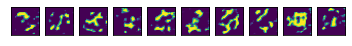

Epoch: [29] [  50/ 200] D_loss: 2.86134672, G_loss: 0.73070419
Epoch: [29] [ 100/ 200] D_loss: 2.82867718, G_loss: 0.91764879
Epoch: [29] [ 150/ 200] D_loss: 2.82181501, G_loss: 0.92443174
Epoch: [29] [ 200/ 200] D_loss: 2.81791520, G_loss: 0.94301885


<Figure size 72x720 with 0 Axes>

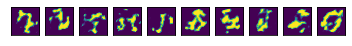

KeyboardInterrupt: ignored

In [13]:
params = {'beta1': 0.05, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':100}
params['z_dim'] = 128
params['base_size'] = 64

gan = GAN(params)


gan.train()